In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BezierCurve import BezierCurve
from numpy.random import randn

In [2]:
def DrawControlPoints(control_points):
    ct_x = [ct[0] for ct in control_points]
    ct_y = [ct[1] for ct in control_points]
    plt.plot(ct_x, ct_y, linestyle='dashed', linewidth=1)
    plt.scatter(gt_x, gt_y, s=1)

def BezierPoints(bezier_curve):
    x = np.arange(0, 1, 0.01, dtype=np.float32)
    x = np.append(x, 1.0)
    points = [bezier_curve.CurvePoint(t) for t in x]
    return points

def DrawBezierCurve(curve_points, color='b'):
    gt_x = [g[0] for g in curve_points]
    gt_y = [g[1] for g in curve_points]
    plt.plot(gt_x, gt_y, linewidth = 1, c=color)

def DrawBezierPoints(curve_points):
    gt_x = [g[0] for g in curve_points]
    gt_y = [g[1] for g in curve_points]
    plt.scatter(gt_x, gt_y, s=1, c='r')

def AddNoize(target_points):
    np.random.seed(0)
    noize_x = np.random.uniform(-0.5, 0.5, 101)
    noize_y = np.random.uniform(-0.5, 0.5, 101)

    def noize_gt_y(pt, idx):
        if idx == 0 or idx == 100:
            # 始終点にはノイズなし
            return pt
        else:
            pt[1] =  pt[1] + noize_y[idx]
            return pt

    noized_points = [noize_gt_y(pt, idx) for idx, pt in enumerate(target_points)]

    return noized_points


# 学習用データ作成

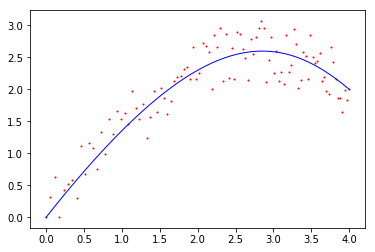

In [4]:
# （確認）ベジェ曲線上の点にノイズを乗せてプロット
points = np.array([[0,0], [2,3], [3,3], [4, 2]], dtype=np.float32)
bezier_curve = BezierCurve(points)
bezier_points1 = BezierPoints(bezier_curve)
bezier_points2 = BezierPoints(bezier_curve)
noized_points = AddNoize(bezier_points2)
DrawBezierCurve(bezier_points1)
DrawBezierPoints(noized_points)

In [5]:
x = np.arange(0, 1, 0.01, dtype=np.float32)
x = np.append(x, 1.0)
# sampling points
gt = [bezier_curve.CurvePoint(t) for t in x]
# control points
ct =bezier_curve.GetControlPoints()

In [10]:
np.random.seed(0)
ct_noize_x = np.random.uniform(-2, 1, 10000)
ct_noize_y = np.random.uniform(-2, 1, 10000)

# 制御点を変えながらベジェ曲線を構成する点群を作成（100線分）
sampling_points = []
control_points = []
sample_curve_num = 100
for i in range(sample_curve_num):
    points = np.array([[0,0], [2,3], [3, 3], [4, 2]], dtype=np.float32)
    idx = i * 2
    points[1][0] += ct_noize_x[idx]
    points[1][1] += ct_noize_y[idx]
    points[2][0] += ct_noize_x[idx+1]
    points[2][1] += ct_noize_y[idx+1]
    
    bezier_curve = BezierCurve(points)
    bezier_points = BezierPoints(bezier_curve)
    noized_points = AddNoize(bezier_points)

    control_points.append(points)
    sampling_points.append(noized_points)

In [12]:
# ノイズを乗せたベジェ曲線の点群（説明変数）
sampling_x = []
for idx in range(len(sampling_points)):
    sampling_x.append(np.array([sp[0] for sp in sampling_points[idx]]))

sampling_y = []
for idx in range(len(sampling_points)):
    sampling_y.append(np.array([sp[1] for sp in sampling_points[idx]]))

# 制御点群（目的変数）
control_x = []
for idx in range(len(control_points)):
    control_x.append(np.array([cp[0] for cp in control_points[idx]]))

control_y = []
for idx in range(len(control_points)):
    control_y.append(np.array([cp[1] for cp in control_points[idx]]))

In [13]:
# サイズを確認
print(np.shape(sampling_x))
print(np.shape(sampling_y))
print(np.shape(control_x))
print(np.shape(control_y))

(100, 101)
(100, 101)
(100, 4)
(100, 4)


# 学習

In [14]:
df_bezier_x = pd.DataFrame(sampling_x)
df_bezier_y = pd.DataFrame(sampling_y)
df_control_x = pd.DataFrame(control_x)
df_control_y = pd.DataFrame(control_y)
df_bezier_x.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.049349,0.098606,0.147768,0.196834,0.245799,0.294661,0.343416,0.392063,0.440597,...,3.754000,3.782813,3.811263,3.839347,3.867062,3.894405,3.921374,3.947964,3.974174,4.0
1,0.0,0.053956,0.107331,0.160136,0.212379,0.264069,0.315216,0.365828,0.415915,0.465486,...,3.643344,3.681886,3.720678,3.759729,3.799050,3.838648,3.878533,3.918714,3.959199,4.0
2,0.0,0.038247,0.076725,0.115428,0.154351,0.193488,0.232832,0.272377,0.312118,0.352048,...,3.699216,3.733951,3.768372,3.802471,3.836244,3.869685,3.902786,3.935544,3.967950,4.0
3,0.0,0.039695,0.080001,0.120900,0.162373,0.204402,0.246968,0.290053,0.333638,0.377705,...,3.865067,3.884530,3.902919,3.920215,3.936400,3.951454,3.965360,3.978098,3.989651,4.0
4,0.0,0.085646,0.169151,0.250551,0.329885,0.407189,0.482500,0.555856,0.627295,0.696854,...,3.558997,3.602627,3.647512,3.693690,3.741198,3.790074,3.840355,3.892078,3.945280,4.0


In [16]:
# トレーニングデータと学習データに分割
from sklearn.model_selection import train_test_split
n1x_train, n1x_test, ct1x_train, ct1x_test = train_test_split(df_bezier_x, df_control_x[1], test_size = 0.2, random_state = 42)
n2x_train, n2x_test, ct2x_train, ct2x_test = train_test_split(df_bezier_x, df_control_x[2], test_size = 0.2, random_state = 42)
n1y_train, n1y_test, ct1y_train, ct1y_test = train_test_split(df_bezier_y, df_control_y[1], test_size = 0.2, random_state = 42)
n2y_train, n2y_test, ct2y_train, ct2y_test = train_test_split(df_bezier_y, df_control_y[2], test_size = 0.2, random_state = 42)

In [19]:
from sklearn.linear_model import LinearRegression

# control point x1
model_LR_cx1 = LinearRegression()
model_LR_cx1.fit(n1x_train, ct1x_train)

# control point x2
model_LR_cx2 = LinearRegression()
model_LR_cx2.fit(n2x_train, ct2x_train)

# control point x1
model_LR_cy1 = LinearRegression()
model_LR_cy1.fit(n1y_train, ct1y_train)

# control point x2
model_LR_cy2 = LinearRegression()
model_LR_cy2.fit(n2y_train, ct2y_train)

print('decistion score test >>>>')
print('control_point_x1 : ', model_LR_cx1.score(n1x_test, ct1x_test))
print('control_point_y1 : ', model_LR_cy1.score(n1y_test, ct1y_test))
print('control_point_x2 : ', model_LR_cx2.score(n2x_test, ct2x_test))
print('control_point_y2 : ', model_LR_cy2.score(n2y_test, ct2y_test))


decistion score test >>>>
control_point_x1 :  0.9999999999999976
control_point_y1 :  0.9999999999999941
control_point_x2 :  0.9999999999999885
control_point_y2 :  0.9999999999999943


# テスト

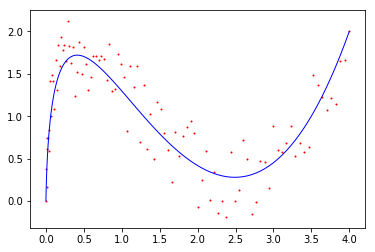

In [22]:
# 始点[0, 0]、終点[4, 2]、間の制御点位置を適当に設定してベジェ曲線を描く
test_control_point = np.array([[0,0], [0.1,5], [2, -3], [4, 2]], dtype=np.float32)

# 予測対象のベジェ曲線とノイズ付きの点群をとりあえず確認
bezier_curve = BezierCurve(test_control_point)
bezier_points = BezierPoints(bezier_curve)
bezier_points_noize = BezierPoints(bezier_curve)
noized_points = AddNoize(bezier_points_noize)
DrawBezierCurve(bezier_points)
DrawBezierPoints(noized_points)

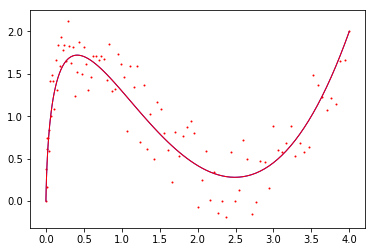

In [23]:
test_point_x = [point[0] for point in noized_points]
test_point_y = [point[1] for point in noized_points]
test_x = np.array([test_point_x])
test_y = np.array([test_point_y])

# 制御点予測
ctx1 = model_LR_cx1.predict(test_x)
cty1 = model_LR_cy1.predict(test_y)
ctx2 = model_LR_cx2.predict(test_x)
cty2 = model_LR_cy2.predict(test_y)

# 予測した制御点
predict_control_points = np.array([test_control_point[0], [ctx1, cty1], [ctx2, cty2], test_control_point[3]])

# 予測した制御点でベジェ曲線を描く
predict_bezier_curve = BezierCurve(predict_control_points)
predict_bezier_points = BezierPoints(predict_bezier_curve)

#print(predict_control_points)
DrawBezierCurve(bezier_points)
DrawBezierCurve(predict_bezier_points, 'red')
DrawBezierPoints(noized_points)